In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
import folium
import json

In [2]:
random_seed = 928579235

In [3]:
df = pd.read_csv("./data/derivedData/combined_df.csv")

In [4]:
df.columns

Index(['GEOID', 'Geography', 'state', 'county', 'tract', 'Total_Population',
       'Total_Households', 'Median_Household_Income', 'Uninsured_Rate',
       'Rent_as_Income_Percentage', 'Limited_English_Proficiency_Rate',
       'No_Vehicle_Rate', 'No_Internet_Rate', 'latitude', 'longitude',
       'Common State County FIPS Code', 'HPSA Designation Date', 'HPSA Score',
       'HPSA Status Code', 'clinic', 'dentist', 'doctors', 'hospital',
       'nursing_home', 'pharmacy', 'social_facility', 'TractFIPS', 'StateAbbr',
       'PlaceName', 'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev',
       'BPHIGH_CrudePrev', 'BPMED_CrudePrev', 'CANCER_CrudePrev',
       'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'CHECKUP_CrudePrev',
       'CHOLSCREEN_CrudePrev', 'COPD_CrudePrev', 'CSMOKING_CrudePrev',
       'DENTAL_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev',
       'KIDNEY_CrudePrev', 'LPA_CrudePrev', 'MHLTH_CrudePrev',
       'OBESITY_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev',
       'STROK

In [5]:
colsofinterest = [
    'GEOID',
    'Total_Population', 
    'Median_Household_Income', 
    'Uninsured_Rate',
    'Rent_as_Income_Percentage', 
    'Limited_English_Proficiency_Rate', 
    'No_Vehicle_Rate', 
    'No_Internet_Rate',
    'HPSA Score', 
    'doctors',
    'hospital',
    'ARTHRITIS_CrudePrev',
    'BINGE_CrudePrev',
    'CANCER_CrudePrev',
    'CASTHMA_CrudePrev',
    'CHD_CrudePrev',
    'CHECKUP_CrudePrev',
    'DIABETES_CrudePrev', 
    'OBESITY_CrudePrev', 
    'CHOLSCREEN_CrudePrev', 
    #, "COLON_SCREEN_CrudePrev", "PAPTEST_CrudePrev"
    'STROKE_CrudePrev'
]

In [6]:
df = df[colsofinterest]

In [7]:
# Define the identifier column
identifier = 'GEOID'

# Define a conversion threshold (e.g., keep columns with at least 80% numeric values)
threshold = 0.8
num_rows = df.shape[0]
numeric_cols = []

# Evaluate each column (except the identifier) for numeric conversion
for col in df.columns:
    if col == identifier:
        continue
    # Attempt to convert to numeric; non-convertible entries become NaN
    col_numeric = pd.to_numeric(df[col], errors='coerce')
    # Calculate the fraction of non-NaN entries
    conversion_rate = col_numeric.notnull().sum() / num_rows
    if conversion_rate >= threshold:
        numeric_cols.append(col)
    else:
        print(f"Dropping column '{col}' (conversion rate: {conversion_rate:.2f}) due to insufficient numeric data.")

# Create a new dataframe that includes only the GEOID and the acceptable numeric columns
df_numeric = df[[identifier] + numeric_cols].copy()

# Ensure all candidate columns are properly converted to numeric
for col in numeric_cols:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# Drop any rows that have missing values in the numeric columns
df_numeric = df_numeric.dropna()

# Prepare features for clustering by dropping the identifier column
features = df_numeric.drop(columns=[identifier])

# Scale the features so each contributes equally
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### exploratory data analysis

In [12]:
df.describe()

GEOID  Total_Population  Median_Household_Income  \
count  2.266800e+04      22668.000000             22668.000000   
mean   2.555106e+10       4038.674740             70628.794468   
std    1.653357e+10       1692.839822             36902.504196   
min    1.073000e+09         25.000000              2499.000000   
25%    6.111006e+09       2788.750000             44213.000000   
50%    2.502511e+10       3889.000000             63137.500000   
75%    3.906101e+10       5092.250000             88308.000000   
max    5.602100e+10      17960.000000            250001.000000   

       Uninsured_Rate  Rent_as_Income_Percentage  \
count    22668.000000               22668.000000   
mean         1.202182                  32.112096   
std          1.708348                   7.994557   
min          0.000000                   9.000000   
25%          0.000000                  26.600000   
50%          0.580000                  30.900000   
75%          1.660000                  36.500000   
max         25.220000                  51.000000   

       Limited_English_Proficiency_Rate  No_Vehicle_Rate  No_Internet_Rate  \
count                      22668.000000     22668.000000      22668.000000   
mean                          93.885339         2.663460         11.056168   
std                            3.059754         3.931591          9.051220   
min                           67.720000         0.000000          0.000000   
25%                           92.200000         0.450000          4.420000   
50%                           94.190000         1.410000          8.770000   
75%                           95.990000         3.250000         15.260000   
max                          100.000000        55.050000         75.070000   

         HPSA Score       doctors  ...  ARTHRITIS_CrudePrev  BINGE_CrudePrev  \
count  22668.000000  22668.000000  ...         22668.000000     22668.000000   
mean      13.749956      4.973796  ...            21.752118        17.930232   
std        4.360304     11.127361  ...             5.856095         3.981950   
min        0.000000      0.000000  ...             2.900000         2.800000   
25%       12.000000      0.000000  ...            17.700000        15.400000   
50%       14.000000      1.000000  ...            21.300000        17.700000   
75%       16.000000      4.000000  ...            25.400000        20.100000   
max       23.000000    180.000000  ...            58.400000        38.100000   

       CANCER_CrudePrev  CASTHMA_CrudePrev  CHD_CrudePrev  CHECKUP_CrudePrev  \
count      22668.000000       22668.000000   22668.000000       22668.000000   
mean           5.711007           9.823231       5.707826          69.259335   
std            1.760703           1.709698       2.047551           6.143036   
min            0.800000           5.600000       0.300000          46.800000   
25%            4.500000           8.500000       4.400000          64.800000   
50%            5.500000           9.500000       5.400000          68.900000   
75%            6.600000          10.900000       6.800000          73.600000   
max           22.900000          17.800000      23.200000          90.200000   

       DIABETES_CrudePrev  OBESITY_CrudePrev  CHOLSCREEN_CrudePrev  \
count        22668.000000       22668.000000          22668.000000   
mean            11.007213          30.671303             78.881489   
std              4.234163           8.239827              5.830096   
min              0.900000           9.600000             33.900000   
25%              8.100000          24.600000             75.700000   
50%             10.300000          29.700000             79.500000   
75%             13.100000          36.000000             82.800000   
max             34.900000          58.600000             95.700000   

       STROKE_CrudePrev  
count      22668.000000  
mean           3.279804  
std            1.431539  
min            0.300000  
25%            2.300000  
50%            3.0

### visualizing structure of the data

In [13]:
def visualize_data_structure(features_scaled, random_state=random_seed):
    """
    Generate 2D visualizations using PCA, t-SNE, and UMAP to explore 
    the intrinsic structure of the data without using clustering labels.
    
    Parameters:
        features_scaled: Scaled feature matrix (numpy array or pandas DataFrame)
        random_state: Seed for reproducibility
    """
    # PCA: Linear reduction capturing maximum variance directions.
    pca = PCA(n_components=2, random_state=random_state)
    pca_components = pca.fit_transform(features_scaled)
    
    # t-SNE: Non-linear reduction emphasizing local neighborhood relationships.
    tsne = TSNE(n_components=2, random_state=random_state,
                perplexity=50)
    tsne_components = tsne.fit_transform(features_scaled)
    
    # UMAP: Non-linear method balancing local structure with global geometry.
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    umap_components = reducer.fit_transform(features_scaled)

    # Set up subplots: one for each dimensionality reduction technique.
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PCA Scatter Plot
    axes[0].scatter(pca_components[:, 0], pca_components[:, 1], 
                    cmap='viridis', alpha=0.7)
    axes[0].set_title("PCA")
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")
    
    # t-SNE Scatter Plot
    axes[1].scatter(tsne_components[:, 0], tsne_components[:, 1],
                    cmap='viridis', alpha=0.7)
    axes[1].set_title("t-SNE")
    axes[1].set_xlabel("t-SNE Component 1")
    axes[1].set_ylabel("t-SNE Component 2")
    
    # UMAP Scatter Plot
    axes[2].scatter(umap_components[:, 0], umap_components[:, 1],
                    cmap='viridis', alpha=0.7)
    axes[2].set_title("UMAP")
    axes[2].set_xlabel("UMAP Component 1")
    axes[2].set_ylabel("UMAP Component 2")
    
    plt.suptitle("Dimensionality Reduction Visualizations (No Clustering Labels)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_55911/376123875.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(pca_components[:, 0], pca_components[:, 1],
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_55911/376123875.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(tsne_components[:, 0], tsne_components[:, 1],
/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/

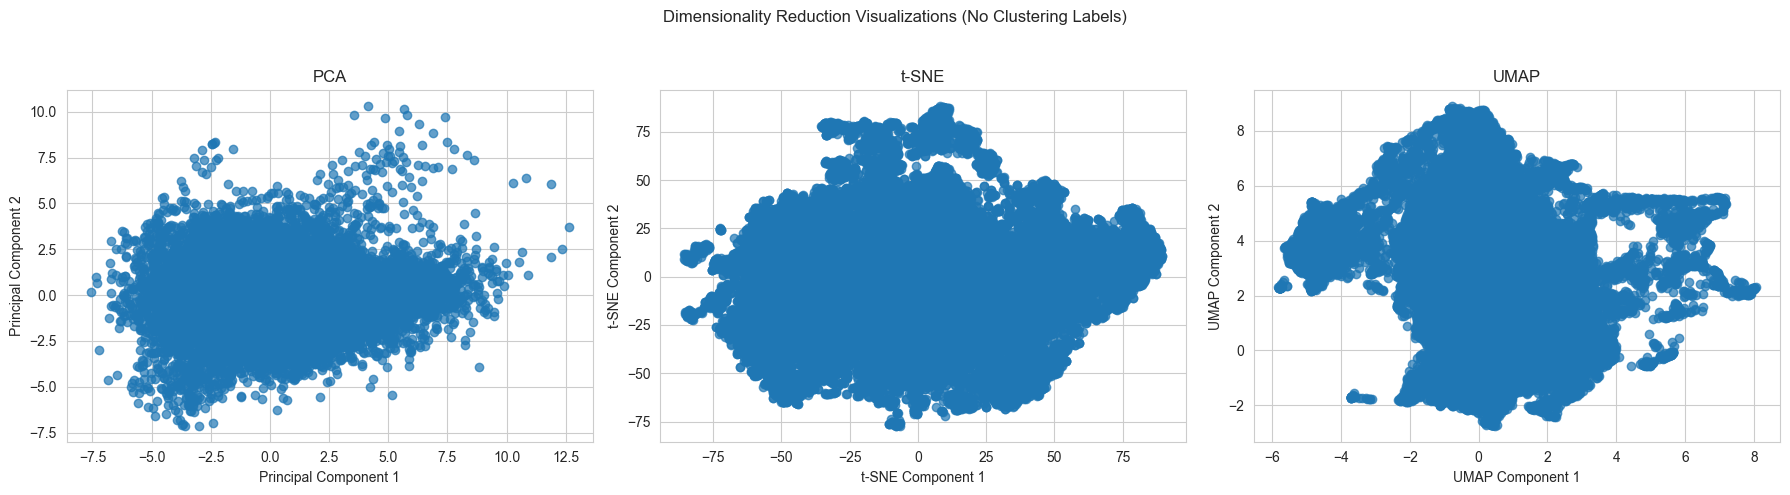

In [14]:
# Example usage:
# Assuming features_scaled is your scaled feature matrix:
visualize_data_structure(features_scaled)

In [20]:
def visualize_data_structure_3d(features_scaled, random_state=random_seed):
    """
    Generate 3D visualizations using PCA, t-SNE, and UMAP to explore
    the intrinsic structure of the data without using clustering labels.
    Uses Plotly for interactive visualization.
    
    Parameters:
        features_scaled: Scaled feature matrix (numpy array or pandas DataFrame)
        random_state: Seed for reproducibility
    """
    # PCA: Linear reduction capturing maximum variance directions.
    pca = PCA(n_components=3, random_state=random_state)
    pca_components = pca.fit_transform(features_scaled)
    
    # t-SNE: Non-linear reduction emphasizing local neighborhood relationships.
    tsne = TSNE(n_components=3, random_state=random_state, perplexity=50)
    tsne_components = tsne.fit_transform(features_scaled)
    
    # UMAP: Non-linear method balancing local structure with global geometry.
    reducer = umap.UMAP(n_components=3, random_state=random_state)
    umap_components = reducer.fit_transform(features_scaled)
    
    # Create a subplot with 1 row and 3 columns for 3D visualizations.
    fig = make_subplots(rows=3, cols=1,
                        subplot_titles=("PCA (3D)", "t-SNE (3D)", "UMAP (3D)"),
                        specs=[
                                [{'type': 'scatter3d'}],
                                [{'type': 'scatter3d'}],
                                [{'type': 'scatter3d'}]
                              ])
    
    # PCA 3D Scatter Plot
    fig.add_trace(
        go.Scatter3d(
            x=pca_components[:, 0],
            y=pca_components[:, 1],
            z=pca_components[:, 2],
            mode='markers',
            marker=dict(size=3, opacity=0.7, colorscale='Viridis'),
            name='PCA'
        ),
        row=1, col=1
    )
    
    # t-SNE 3D Scatter Plot
    fig.add_trace(
        go.Scatter3d(
            x=tsne_components[:, 0],
            y=tsne_components[:, 1],
            z=tsne_components[:, 2],
            mode='markers',
            marker=dict(size=3, opacity=0.7, colorscale='Viridis'),
            name='t-SNE'
        ),
        row=2, col=1
    )
    
    # UMAP 3D Scatter Plot
    fig.add_trace(
        go.Scatter3d(
            x=umap_components[:, 0],
            y=umap_components[:, 1],
            z=umap_components[:, 2],
            mode='markers',
            marker=dict(size=3, opacity=0.7, colorscale='Viridis'),
            name='UMAP'
        ),
        row=3, col=1
    )
    
    # Update overall layout for aesthetics and clarity.
    #fig.update_layout(
    #    title_text="3D Dimensionality Reduction Visualizations (Plotly)",
    #    height=600,
    #    width=1800,
    #    scene=dict(
    #        xaxis_title="Component 1",
    #        yaxis_title="Component 2",
    #        zaxis_title="Component 3"
    #    ),
    #    template="plotly_white"
    #)
    
    fig.show()

In [21]:
visualize_data_structure_3d(features_scaled)

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/asteroidhunter/PycharmProjects/healthcare-accessibility-ai/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



The data isn't spherical, so k-means wouldn't be a suitable algorithm for analysis.

### performing clustering 